# Financial Sentiment Analysis

## About Dataset

### Data

The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels.

### Import the Libraries

In [57]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import classification_report, confusion_matrix, f1_score



In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Import the dataset 

In [3]:
df = pd.read_csv('./data.csv')

In [4]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.shape

(5842, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [7]:
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

In [8]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

#### EDA

### Word Cloud for Positive Sentence

In [9]:
df_positive_sentiment = df[ df['Sentiment'] == 'positive' ]
df_negative_sentiment = df[ df['Sentiment'] == 'negative' ]
df_neutral_sentiment = df[ df['Sentiment'] == 'neutral' ]

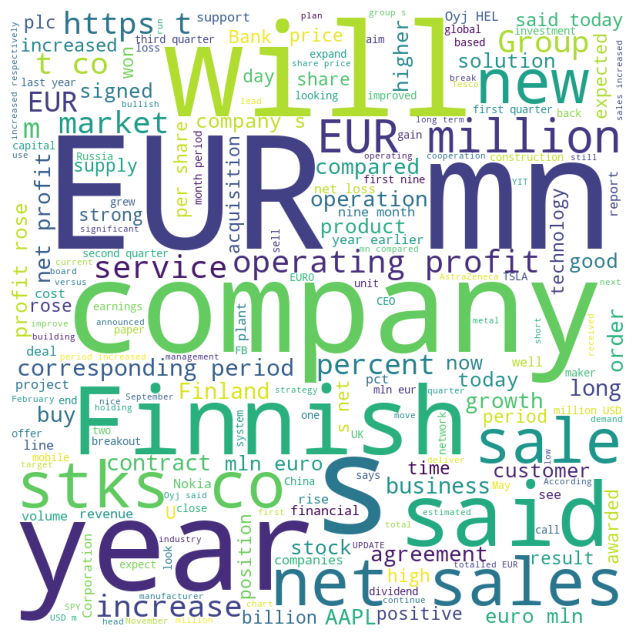

In [10]:
all_positive_sentence = "".join([ char for char in df_positive_sentiment['Sentence'] ])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(all_positive_sentence)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word Cloud for Negative Sentiment

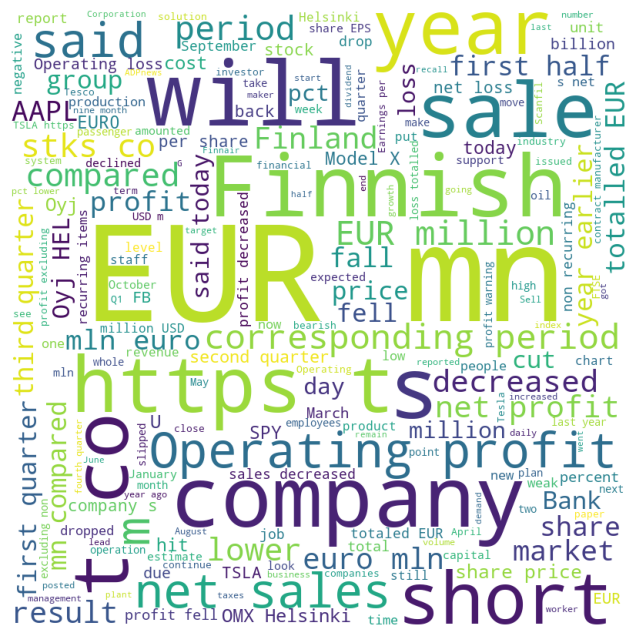

In [11]:
all_negative_sentence = "".join([ char for char in df_negative_sentiment['Sentence'] ])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(all_negative_sentence)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Data Preprocessing 

#### Remove Punctuation

In [12]:
import string

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def remove_punctuation(text):
    return "".join([ char for char in text if char not in string.punctuation ])

In [15]:
df['removed_punctation_sentence'] = df['Sentence'].apply( lambda x: remove_punctuation(x))


In [16]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...


In [17]:
df['Sentence'][0]

"The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."

In [18]:
df['removed_punctation_sentence'][0]

'The GeoSolutions technology will leverage Benefon s GPS solutions by providing Location Based Search Technology  a Communities Platform  location relevant multimedia content and a new and powerful commercial model '

#### Convert all text to lower case

In [19]:
def text_lowercase_and_remove_empty_space(text):
    return str(text).lower().strip()

In [20]:
df['text_to_lower_case_after_removing_punctuation'] = df['removed_punctation_sentence'].apply( lambda x: text_lowercase_and_remove_empty_space(x))

In [21]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...


In [22]:
df.tail()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation
5837,RISING costs have forced packaging producer Hu...,negative,RISING costs have forced packaging producer Hu...,rising costs have forced packaging producer hu...
5838,Nordic Walking was first used as a summer trai...,neutral,Nordic Walking was first used as a summer trai...,nordic walking was first used as a summer trai...
5839,"According shipping company Viking Line , the E...",neutral,According shipping company Viking Line the EU...,according shipping company viking line the eu...
5840,"In the building and home improvement trade , s...",neutral,In the building and home improvement trade sa...,in the building and home improvement trade sa...
5841,HELSINKI AFX - KCI Konecranes said it has won ...,positive,HELSINKI AFX KCI Konecranes said it has won a...,helsinki afx kci konecranes said it has won a...


### Tokenize the data

In [23]:
def tokenize(text):
    return re.split('\W+', text)

In [24]:
df['tokenize_sentence'] = df['text_to_lower_case_after_removing_punctuation'].apply( lambda x: tokenize(x))

In [25]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation,tokenize_sentence
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility,"[esi, on, lows, down, 150, to, 250, bk, a, rea..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...,"[for, the, last, quarter, of, 2010, componenta..."
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...,"[according, to, the, finnishrussian, chamber, ..."
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r..."


### Remove Stop words

In [26]:
def remove_stopwords(tokenize):
    stop_words = stopwords.words('english')
    return [ word for word in tokenize if word not in stop_words ]

In [27]:
df['removed_stopword_in_tokenize_sentence'] = df['tokenize_sentence'].apply(lambda x: remove_stopwords(x))

In [28]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation,tokenize_sentence,removed_stopword_in_tokenize_sentence
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage...","[geosolutions, technology, leverage, benefon, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility,"[esi, on, lows, down, 150, to, 250, bk, a, rea...","[esi, lows, 150, 250, bk, real, possibility]"
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...,"[for, the, last, quarter, of, 2010, componenta...","[last, quarter, 2010, componenta, net, sales, ..."
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...,"[according, to, the, finnishrussian, chamber, ...","[according, finnishrussian, chamber, commerce,..."
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r...","[swedish, buyout, firm, sold, remaining, 224, ..."


### Lemmatization

Strip words to it roots form

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
def lemmatize(tokenize_text):
    lm = WordNetLemmatizer()
    return [ lm.lemmatize(word) for  word in tokenize_text ]

In [31]:
df['lemmatize_text'] = df['removed_stopword_in_tokenize_sentence'].apply( lambda x: lemmatize(x))

In [32]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation,tokenize_sentence,removed_stopword_in_tokenize_sentence,lemmatize_text
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage...","[geosolutions, technology, leverage, benefon, ...","[geosolutions, technology, leverage, benefon, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility,"[esi, on, lows, down, 150, to, 250, bk, a, rea...","[esi, lows, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibility]"
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...,"[for, the, last, quarter, of, 2010, componenta...","[last, quarter, 2010, componenta, net, sales, ...","[last, quarter, 2010, componenta, net, sale, d..."
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...,"[according, to, the, finnishrussian, chamber, ...","[according, finnishrussian, chamber, commerce,...","[according, finnishrussian, chamber, commerce,..."
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remaining, 224, ..."


### Stemming

In [33]:
def stemming(tokenize_text):
    st = PorterStemmer()
    return [ st.stem(word) for word in tokenize_text ]

In [34]:
df['stem_text'] = df['removed_stopword_in_tokenize_sentence'].apply( lambda x: stemming(x))

In [35]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation,tokenize_sentence,removed_stopword_in_tokenize_sentence,lemmatize_text,stem_text
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage...","[geosolutions, technology, leverage, benefon, ...","[geosolutions, technology, leverage, benefon, ...","[geosolut, technolog, leverag, benefon, gp, so..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility,"[esi, on, lows, down, 150, to, 250, bk, a, rea...","[esi, lows, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibl]"
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...,"[for, the, last, quarter, of, 2010, componenta...","[last, quarter, 2010, componenta, net, sales, ...","[last, quarter, 2010, componenta, net, sale, d...","[last, quarter, 2010, componenta, net, sale, d..."
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...,"[according, to, the, finnishrussian, chamber, ...","[according, finnishrussian, chamber, commerce,...","[according, finnishrussian, chamber, commerce,...","[accord, finnishrussian, chamber, commerc, maj..."
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remain, 224, per..."


### Clean Data

In [36]:
def clean_data(tokenize_text):
    return " ".join([ word for word in tokenize_text ])

In [37]:
df['clean_sentence_stem'] = df['stem_text'].apply( lambda x: clean_data(x) )
df['clean_sentence_lemmatize'] = df['lemmatize_text'].apply( lambda x: clean_data(x) )

In [38]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation,tokenize_sentence,removed_stopword_in_tokenize_sentence,lemmatize_text,stem_text,clean_sentence_stem,clean_sentence_lemmatize
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage...","[geosolutions, technology, leverage, benefon, ...","[geosolutions, technology, leverage, benefon, ...","[geosolut, technolog, leverag, benefon, gp, so...",geosolut technolog leverag benefon gp solut pr...,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility,"[esi, on, lows, down, 150, to, 250, bk, a, rea...","[esi, lows, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibl]",esi low 150 250 bk real possibl,esi low 150 250 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...,"[for, the, last, quarter, of, 2010, componenta...","[last, quarter, 2010, componenta, net, sales, ...","[last, quarter, 2010, componenta, net, sale, d...","[last, quarter, 2010, componenta, net, sale, d...",last quarter 2010 componenta net sale doubl eu...,last quarter 2010 componenta net sale doubled ...
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...,"[according, to, the, finnishrussian, chamber, ...","[according, finnishrussian, chamber, commerce,...","[according, finnishrussian, chamber, commerce,...","[accord, finnishrussian, chamber, commerc, maj...",accord finnishrussian chamber commerc major co...,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remain, 224, per...",swedish buyout firm sold remain 224 percent st...,swedish buyout firm sold remaining 224 percent...


In [39]:
le = LabelEncoder()
df['sentiment_cat'] = le.fit_transform(df['Sentiment'])

In [40]:
df.head()

,Sentence,Sentiment,removed_punctation_sentence,text_to_lower_case_after_removing_punctuation,tokenize_sentence,removed_stopword_in_tokenize_sentence,lemmatize_text,stem_text,clean_sentence_stem,clean_sentence_lemmatize,sentiment_cat
0,The GeoSolutions technology will leverage Bene...,positive,The GeoSolutions technology will leverage Bene...,the geosolutions technology will leverage bene...,"[the, geosolutions, technology, will, leverage...","[geosolutions, technology, leverage, benefon, ...","[geosolutions, technology, leverage, benefon, ...","[geosolut, technolog, leverag, benefon, gp, so...",geosolut technolog leverag benefon gp solut pr...,geosolutions technology leverage benefon gps s...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,ESI on lows down 150 to 250 BK a real possibility,esi on lows down 150 to 250 bk a real possibility,"[esi, on, lows, down, 150, to, 250, bk, a, rea...","[esi, lows, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibility]","[esi, low, 150, 250, bk, real, possibl]",esi low 150 250 bk real possibl,esi low 150 250 bk real possibility,0
2,"For the last quarter of 2010 , Componenta 's n...",positive,For the last quarter of 2010 Componenta s net...,for the last quarter of 2010 componenta s net...,"[for, the, last, quarter, of, 2010, componenta...","[last, quarter, 2010, componenta, net, sales, ...","[last, quarter, 2010, componenta, net, sale, d...","[last, quarter, 2010, componenta, net, sale, d...",last quarter 2010 componenta net sale doubl eu...,last quarter 2010 componenta net sale doubled ...,2
3,According to the Finnish-Russian Chamber of Co...,neutral,According to the FinnishRussian Chamber of Com...,according to the finnishrussian chamber of com...,"[according, to, the, finnishrussian, chamber, ...","[according, finnishrussian, chamber, commerce,...","[according, finnishrussian, chamber, commerce,...","[accord, finnishrussian, chamber, commerc, maj...",accord finnishrussian chamber commerc major co...,according finnishrussian chamber commerce majo...,1
4,The Swedish buyout firm has sold its remaining...,neutral,The Swedish buyout firm has sold its remaining...,the swedish buyout firm has sold its remaining...,"[the, swedish, buyout, firm, has, sold, its, r...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remaining, 224, ...","[swedish, buyout, firm, sold, remain, 224, per...",swedish buyout firm sold remain 224 percent st...,swedish buyout firm sold remaining 224 percent...,1


### Vectorize the data

1. Word of Bags
2. N-Grams
3. Tfidf

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Bags of Words Vectorization

In [42]:
bags_of_words = CountVectorizer(analyzer="word")

df_bow = bags_of_words.fit_transform(df['clean_sentence_stem'])

### N Grams Vectorization

In [43]:
n_grams = CountVectorizer(ngram_range=(2,2), analyzer="word")

n_gram_vector = bags_of_words.fit_transform(df['clean_sentence_stem'])

In [44]:
n_gram_vector.shape

(5842, 10149)

### TF-IDF

In [45]:
tfidf_vector = TfidfVectorizer(analyzer="word")

tfidf = tfidf_vector.fit_transform(df['clean_sentence_stem'])

In [47]:
tfidf.shape

(5842, 10149)

In [ ]:
df

### Train Test Split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, df['sentiment_cat'], test_size=0.3, random_state=42)  

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4089, 10149), (1753, 10149), (4089,), (1753,))

## Model Building

### Using Naiye Bayes Algorithm

In [55]:
mn = MultinomialNB()
mn.fit(X_train, y_train)

MultinomialNB()

In [56]:
y_pred = mn.predict(X_test)

In [63]:
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.03      0.90      0.06        10
           1       0.98      0.62      0.76      1461
           2       0.37      0.73      0.49       282

    accuracy                           0.64      1753
   macro avg       0.46      0.75      0.44      1753
weighted avg       0.87      0.64      0.71      1753

[[  9   1   0]
 [204 904 353]
 [ 56  20 206]]


In [64]:
le = LogisticRegression()
le.fit(X_train, y_train)

LogisticRegression()

In [65]:
y_pred = mn.predict(X_test)

In [66]:
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.03      0.90      0.06        10
           1       0.98      0.62      0.76      1461
           2       0.37      0.73      0.49       282

    accuracy                           0.64      1753
   macro avg       0.46      0.75      0.44      1753
weighted avg       0.87      0.64      0.71      1753

[[  9   1   0]
 [204 904 353]
 [ 56  20 206]]
